## Get all the imports

In [ ]:

import torch
torch.manual_seed(27)
# torch.use_deterministic_algorithms(True)
import random
random.seed(27)
import pandas as pd
import numpy as np
np.random.seed(27)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler

## Load the data and split into train, test and validation

In [ ]:
# Read data
df = pd.read_csv("AirPassengers.csv")
# Convert the Month column to type "datetime" for easier manipulation of data
df["Month"] = pd.to_datetime(df["Month"], format='%Y-%m')
# Split the data into train, valid and test
df_train = df.loc[df["Month"].dt.year < 1957]
df_val = df.loc[(df["Month"].dt.year >= 1957) & (df["Month"].dt.year < 1959)]
df_test = df.loc[df["Month"].dt.year >= 1959]
# Check out the splits
print("Training Split with number of samples:", len(df_train))
display(df_train.head())
print("\n\nValidation Split with number of samples:", len(df_val))
display(df_val.head())
print("\n\nTest Split with number of samples:", len(df_test))
display(df_test.head())

# Scale the values appropriately
scaler = MinMaxScaler()
df_train["#Passengers"] = scaler.fit_transform(np.reshape(df_train["#Passengers"].values, (-1, 1)))[:,0]
df_val["#Passengers"] = scaler.transform(np.reshape(df_val["#Passengers"].values, (-1, 1)))[:,0]
df_test["#Passengers"] = scaler.transform(np.reshape(df_test["#Passengers"].values, (-1, 1)))[:,0]

Training Split with number of samples: 96


,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121




Validation Split with number of samples: 24


,Month,#Passengers
96,1957-01-01,315
97,1957-02-01,301
98,1957-03-01,356
99,1957-04-01,348
100,1957-05-01,355




Test Split with number of samples: 24


,Month,#Passengers
120,1959-01-01,360
121,1959-02-01,342
122,1959-03-01,406
123,1959-04-01,396
124,1959-05-01,420


<ipython-input-3-d64e89895be1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["#Passengers"] = scaler.fit_transform(np.reshape(df_train["#Passengers"].values, (-1, 1)))[:,0]
<ipython-input-3-d64e89895be1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["#Passengers"] = scaler.transform(np.reshape(df_val["#Passengers"].values, (-1, 1)))[:,0]
<ipython-input-3-d64e89895be1>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

## Check out the data trend

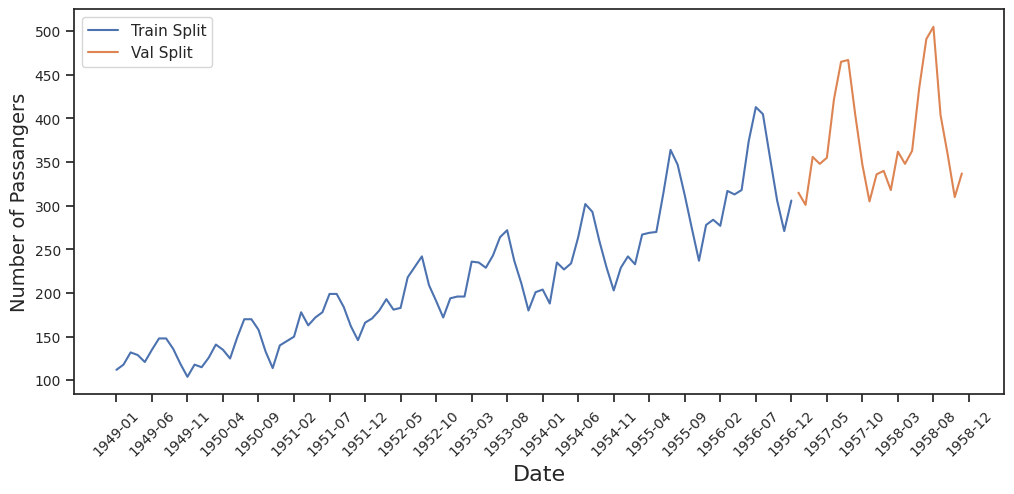

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(x=np.arange(len(df_train)), y=scaler.inverse_transform(np.reshape(df_train["#Passengers"].values, (-1, 1)))[:,0], label="Train Split")
sns.lineplot(x=np.arange(len(df_train), len(df_train)+len(df_val)), y=scaler.inverse_transform(np.reshape(df_val["#Passengers"].values, (-1, 1)))[:,0], label="Val Split")
train_ticks = [i for idx, i in enumerate(df_train["Month"].dt.strftime("%Y-%m").tolist()) if idx%5==0]
val_ticks = [i for idx, i in enumerate(df_val["Month"].dt.strftime("%Y-%m").tolist()) if (idx+1)%5==0] + [df_val["Month"].dt.strftime("%Y-%m").tolist()[-1]]
plt.xticks(np.arange(0, len(df_train)+len(df_val)+1, 5), train_ticks + val_ticks, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of Passangers", fontsize=14)
plt.legend()
plt.show()

## Design the data module responsible for data processing and generating data loaders

In [ ]:
class DataModule:
    def __init__(self, window_size, stride, batch_size):
        self.window_size = window_size
        self.stride = stride
        self.batch_size = batch_size

    def convert_data_to_sequence_format(self, data):
        X, Y = list(), list()
        for i in range(0, len(data)-self.window_size, self.stride):
            X.append(data[i:i+self.window_size])
            Y.append(data[i+self.window_size])
        X, Y = np.asarray(X), np.asarray(Y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        return X, Y

    def data_loader(self, X, Y, shuffle=True):
        return DataLoader(TensorDataset(torch.tensor(X), torch.tensor(Y)), batch_size=self.batch_size, shuffle=shuffle)

## Design a Custom RNN cell

In [ ]:
class RNNCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size,
                 activation="tanh", bias=True):
        super(RNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation = {"tanh": torch.nn.Tanh(),
                              "sigmoid": torch.nn.Sigmoid(),
                              "relu": torch.nn.ReLU()}[activation]
        self.input_layer = torch.nn.Linear(self.input_size, self.hidden_size, bias=bias)
        self.hidden_layer = torch.nn.Linear(self.hidden_size, self.hidden_size, bias=bias)

    def forward(self, x):
        output = list()
        ht = torch.rand((x.shape[0], self.hidden_size)).to(x.device)
        ht = ht/torch.sqrt(torch.sum(torch.square(ht), dim=0))
        for i in range(x.shape[1]):
            ht = self.activation(self.input_layer(x[:,i]) + self.hidden_layer(ht))
            output.append(ht)
        output = torch.stack(output)
        output = torch.swapdims(output, 0, 1)
        return output

## Define the Custom RNN model

In [ ]:
class VanillaRNN(torch.nn.Module):
    def __init__(self, num_layers, input_size, hidden_size,
                 activation, bias,
                 device):
        super(VanillaRNN, self).__init__()
        # Stack up RNN cells to produce a deep RNN model
        self.RNN_layers = list()
        for i in range(num_layers):
            if i == 0:
                self.RNN_layers.append(RNNCell(input_size, hidden_size, activation, bias).to(device))
            else:
                self.RNN_layers.append(RNNCell(hidden_size, hidden_size, activation, bias).to(device))
        self.RNN_layers = torch.nn.Sequential(*self.RNN_layers)
        # The final output layer
        self.linear = torch.nn.Linear(hidden_size, 1)
        # Define the optimizer
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
        # Define the objective function
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        # x = self.RNN_layers(x)
        for i in range(num_layers):
            x = self.RNN_layers[i](x)
        x = self.linear(x[:,-1]).squeeze()
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        self.optimizer.zero_grad()
        preds = self.forward(x.float())
        loss = self.criterion(preds, y.float())
        loss.backward()
        self.optimizer.step()
        return loss.item(), preds.numpy(force=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x.float())
        loss = self.criterion(preds, y.float())
        return loss.item(), preds.numpy(force=True)

## Get the data loaders

In [ ]:
window_size, stride = 18, 1
batch_size = 32

# First process the data into sequential format
data_module = DataModule(window_size, stride, batch_size)
X_train, Y_train = data_module.convert_data_to_sequence_format(df_train["#Passengers"].values)
print("Train data shape:", X_train.shape, Y_train.shape)

X_val, Y_val = data_module.convert_data_to_sequence_format(df_val["#Passengers"].values)
X_val = np.concatenate((X_train[-window_size:], X_val), axis=0)
Y_val = np.concatenate((Y_train[-window_size:], Y_val), axis=0)
print("Val data shape:", X_val.shape, Y_val.shape)

X_test, Y_test = data_module.convert_data_to_sequence_format(df_test["#Passengers"].values)
X_test = np.concatenate((X_val[-window_size:], X_test), axis=0)
Y_test = np.concatenate((Y_val[-window_size:], Y_test), axis=0)
print("Test data shape:", X_test.shape, Y_test.shape)

# Now generate data loaders
train_data_loader = data_module.data_loader(X_train, Y_train, shuffle=True)
val_data_loader = data_module.data_loader(X_val, Y_val, shuffle=False)
test_data_loader = data_module.data_loader(X_test, Y_test, shuffle=False)

Train data shape: (78, 18, 1) (78,)
Val data shape: (24, 18, 1) (24,)
Test data shape: (24, 18, 1) (24,)


## Perform training and validation with our custom RNN

In [ ]:
num_layers = 4
input_size = X_train.shape[-1]
hidden_size = 128
num_epochs = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VanillaRNN(num_layers, input_size, hidden_size, "tanh", True, device).to(device)

train_epoch_loss = list()
val_epoch_loss = list()
min_val_loss = np.inf
for epoch in tqdm(range(num_epochs)):
    # Training loop
    train_iter_loss = list()
    model.train()
    for batch_idx, batch in enumerate(train_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.training_step(batch, batch_idx)
        train_iter_loss.append(loss)
    train_epoch_loss.append(sum(train_iter_loss)/len(train_iter_loss))
    # print("\nAverage Training MSE in Epoch", epoch+1, ":", train_epoch_loss[-1], "\n")

    # Validation loop
    val_iter_loss = list()
    model.eval()
    for batch_idx, batch in enumerate(val_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.validation_step(batch, batch_idx)
        val_iter_loss.append(loss)
    val_epoch_loss.append(sum(val_iter_loss)/len(val_iter_loss))
    if val_epoch_loss[-1] < min_val_loss:
        min_val_loss = val_epoch_loss[-1]
        best_model = deepcopy(model)
    # print("\nAverage Validation MSE in Epoch", epoch+1, ":", val_epoch_loss[-1], "\n")

100%|██████████| 200/200 [00:21<00:00,  9.49it/s]


## Plot the training and validation losses

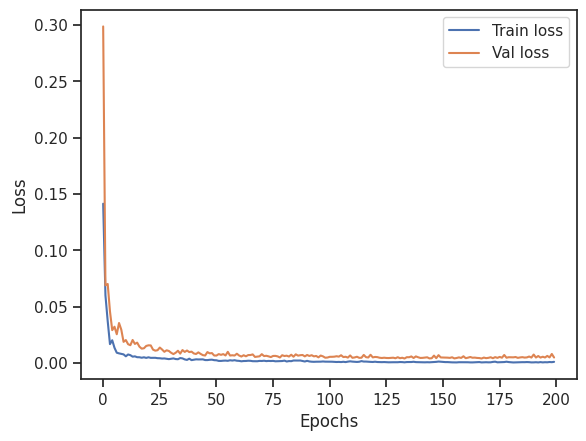

In [ ]:
sns.lineplot(x=np.arange(num_epochs), y=train_epoch_loss, label="Train loss")
sns.lineplot(x=np.arange(num_epochs), y=val_epoch_loss, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Get all the predictions on the train and validation set

In [ ]:
train_data_loader = data_module.data_loader(X_train, Y_train, shuffle=False)
train_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc="Predicting on Train set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    train_total_predictions.extend(preds)
train_total_predictions = np.asarray(train_total_predictions)
train_total_predictions = scaler.inverse_transform(np.reshape(train_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_train, (-1, 1)))[:,0]
print("Training MSE:", np.mean(np.square(train_total_predictions - ground_truth)), "\n\n")

val_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(val_data_loader), total=len(val_data_loader), desc="Predicting on Val set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    val_total_predictions.extend(preds)
val_total_predictions = np.asarray(val_total_predictions)
val_total_predictions = scaler.inverse_transform(np.reshape(val_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_val, (-1, 1)))[:,0]
print("Validation MSE:", np.mean(np.square(val_total_predictions - ground_truth)), "\n\n")

test_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Predicting on Test set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    test_total_predictions.extend(preds)
test_total_predictions = np.asarray(test_total_predictions)
test_total_predictions = scaler.inverse_transform(np.reshape(test_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_test, (-1, 1)))[:,0]
print("Test MSE:", np.mean(np.square(test_total_predictions - ground_truth)))


Predicting on Train set: 100%|██████████| 3/3 [00:00<00:00, 95.22it/s]


Training MSE: 59.655317629965104 




Predicting on Val set: 100%|██████████| 1/1 [00:00<00:00, 88.37it/s]


Validation MSE: 372.1933145757066 




Predicting on Test set: 100%|██████████| 1/1 [00:00<00:00, 89.51it/s]

Test MSE: 4659.435394839618


## Now, plot the ground truth and corresponding predictions

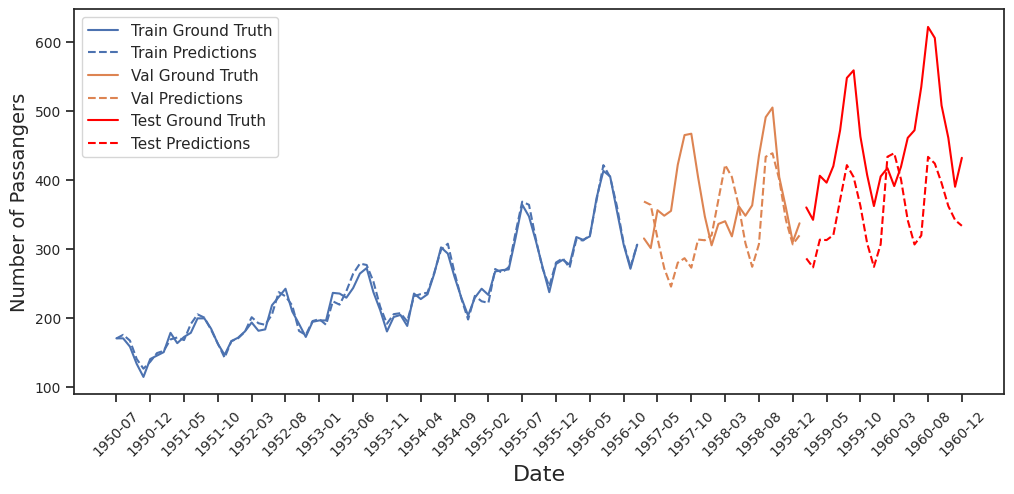

In [ ]:

plt.figure(figsize=(12, 5))
y_value = scaler.inverse_transform(np.reshape(df_train["#Passengers"][window_size:], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:])), y=y_value, label="Train Ground Truth", color="#4c72b0")
sns.lineplot(x=np.arange(len(df_train[window_size:])), y=train_total_predictions, label="Train Predictions", color="#4c72b0", linestyle="--")

y_value = scaler.inverse_transform(np.reshape(df_val["#Passengers"], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:]), len(df_train[window_size:])+len(df_val)), y=y_value, label="Val Ground Truth", color="#dd8452")
sns.lineplot(x=np.arange(len(df_train[window_size:]), len(df_train[window_size:])+len(df_val)), y=val_total_predictions, label="Val Predictions", color="#dd8452", linestyle="--")

y_value = scaler.inverse_transform(np.reshape(df_test["#Passengers"], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:])+len(df_val), len(df_train[window_size:])+len(df_val)+len(df_test)), y=y_value, label="Test Ground Truth", color="red")
sns.lineplot(x=np.arange(len(df_train[window_size:])+len(df_val), len(df_train[window_size:])+len(df_val)+len(df_test)), y=test_total_predictions, label="Test Predictions", color="red", linestyle="--")

train_ticks = [i for idx, i in enumerate(df_train["Month"].dt.strftime("%Y-%m").tolist()[window_size:]) if idx%5==0]
val_ticks = [i for idx, i in enumerate(df_val["Month"].dt.strftime("%Y-%m").tolist()) if (idx+1)%5==0] + [df_val["Month"].dt.strftime("%Y-%m").tolist()[-1]]
test_ticks = [i for idx, i in enumerate(df_test["Month"].dt.strftime("%Y-%m").tolist()) if (idx+1)%5==0] + [df_test["Month"].dt.strftime("%Y-%m").tolist()[-1]]
plt.xticks(np.arange(0, len(df_train[window_size:])+len(df_val)+len(df_test)+1, 5), train_ticks + val_ticks + test_ticks, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of Passangers", fontsize=14)
plt.legend()
plt.show()

## Define the Pytorch RNN model

In [ ]:
class PytorchRNN(torch.nn.Module):
    def __init__(self, num_layers, input_size, hidden_size,
                 activation, bias,
                 device):
        super(PytorchRNN, self).__init__()
        self.RNN = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, nonlinearity=activation, bias=bias, batch_first=True, device=device)
        # The final output layer
        self.linear = torch.nn.Linear(hidden_size, 1)
        # Define the optimizer
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
        # Define the objective function
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        ht = torch.rand((self.RNN.num_layers, x.shape[0], self.RNN.hidden_size)).to(x.device)
        ht = ht/torch.sqrt(torch.sum(torch.square(ht), dim=0))
        x, _ = self.RNN(x, ht)
        x = self.linear(x[:,-1]).squeeze()
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        self.optimizer.zero_grad()
        preds = self.forward(x.float())
        loss = self.criterion(preds, y.float())
        loss.backward()
        self.optimizer.step()
        return loss.item(), preds.numpy(force=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x.float())
        loss = self.criterion(preds, y.float())
        return loss.item(), preds.numpy(force=True)

## Perform Training and Validation using Pytorch RNN

In [ ]:
num_layers = 4
input_size = X_train.shape[-1]
hidden_size = 128
num_epochs = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PytorchRNN(num_layers, input_size, hidden_size, "tanh", True, device).to(device)

train_epoch_loss = list()
val_epoch_loss = list()
min_val_loss = np.inf
for epoch in tqdm(range(num_epochs)):
    # Training loop
    train_iter_loss = list()
    model.train()
    for batch_idx, batch in enumerate(train_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.training_step(batch, batch_idx)
        train_iter_loss.append(loss)
    train_epoch_loss.append(sum(train_iter_loss)/len(train_iter_loss))
    # print("\nAverage Training MSE in Epoch", epoch+1, ":", train_epoch_loss[-1], "\n")

    # Validation loop
    val_iter_loss = list()
    model.eval()
    for batch_idx, batch in enumerate(val_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.validation_step(batch, batch_idx)
        val_iter_loss.append(loss)
    val_epoch_loss.append(sum(val_iter_loss)/len(val_iter_loss))
    if val_epoch_loss[-1] < min_val_loss:
        min_val_loss = val_epoch_loss[-1]
        best_model = deepcopy(model)
    # print("\nAverage Validation MSE in Epoch", epoch+1, ":", val_epoch_loss[-1], "\n")

100%|██████████| 200/200 [00:02<00:00, 80.73it/s]


## Plot the training and validation losses

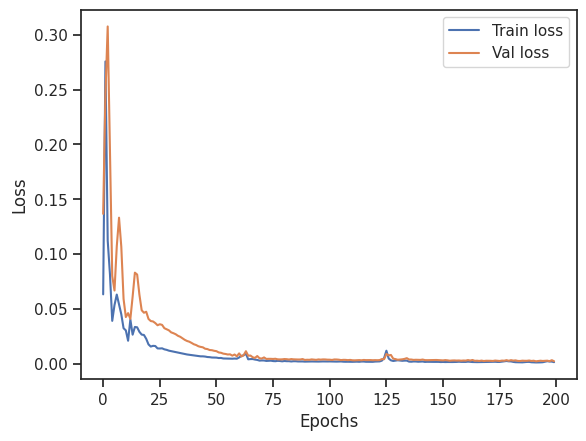

In [ ]:
sns.lineplot(x=np.arange(num_epochs), y=train_epoch_loss, label="Train loss")
sns.lineplot(x=np.arange(num_epochs), y=val_epoch_loss, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Get all the predictions on the train and validation set

In [ ]:
train_data_loader = data_module.data_loader(X_train, Y_train, shuffle=False)
train_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc="Predicting on Train set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    train_total_predictions.extend(preds)
train_total_predictions = np.asarray(train_total_predictions)
train_total_predictions = scaler.inverse_transform(np.reshape(train_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_train, (-1, 1)))[:,0]
print("Training MSE:", np.mean(np.square(train_total_predictions - ground_truth)), "\n\n")

val_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(val_data_loader), total=len(val_data_loader), desc="Predicting on Val set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    val_total_predictions.extend(preds)
val_total_predictions = np.asarray(val_total_predictions)
val_total_predictions = scaler.inverse_transform(np.reshape(val_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_val, (-1, 1)))[:,0]
print("Validation MSE:", np.mean(np.square(val_total_predictions-ground_truth)), "\n\n")

test_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Predicting on Test set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    test_total_predictions.extend(preds)
test_total_predictions = np.asarray(test_total_predictions)
test_total_predictions = scaler.inverse_transform(np.reshape(test_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_test, (-1, 1)))[:,0]
print("Test MSE:", np.mean(np.square(test_total_predictions-ground_truth)))


Predicting on Train set:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:714: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.rnn_tanh(
Predicting on Train set: 100%|██████████| 3/3 [00:00<00:00, 438.60it/s]


Training MSE: 116.9549615500817 




Predicting on Val set:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:714: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.rnn_tanh(
Predicting on Val set: 100%|██████████| 1/1 [00:00<00:00, 361.95it/s]


Validation MSE: 217.54125179564775 




Predicting on Test set:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:714: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.rnn_tanh(
Predicting on Test set: 100%|██████████| 1/1 [00:00<00:00, 367.15it/s]

Test MSE: 1239.629089018874


## Now, plot the ground truth and corresponding predictions

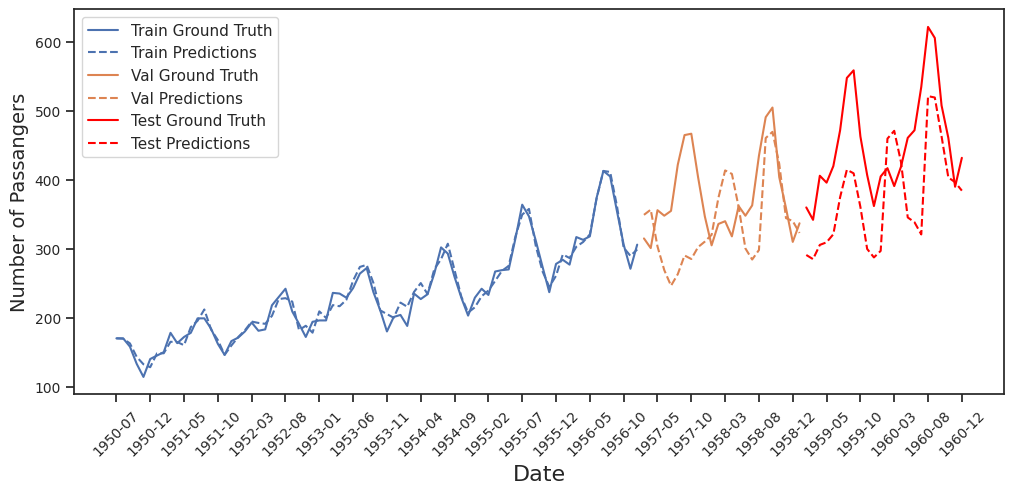

In [ ]:

plt.figure(figsize=(12, 5))
y_value = scaler.inverse_transform(np.reshape(df_train["#Passengers"][window_size:], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:])), y=y_value, label="Train Ground Truth", color="#4c72b0")
sns.lineplot(x=np.arange(len(df_train[window_size:])), y=train_total_predictions, label="Train Predictions", color="#4c72b0", linestyle="--")

y_value = scaler.inverse_transform(np.reshape(df_val["#Passengers"], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:]), len(df_train[window_size:])+len(df_val)), y=y_value, label="Val Ground Truth", color="#dd8452")
sns.lineplot(x=np.arange(len(df_train[window_size:]), len(df_train[window_size:])+len(df_val)), y=val_total_predictions, label="Val Predictions", color="#dd8452", linestyle="--")

y_value = scaler.inverse_transform(np.reshape(df_test["#Passengers"], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:])+len(df_val), len(df_train[window_size:])+len(df_val)+len(df_test)), y=y_value, label="Test Ground Truth", color="red")
sns.lineplot(x=np.arange(len(df_train[window_size:])+len(df_val), len(df_train[window_size:])+len(df_val)+len(df_test)), y=test_total_predictions, label="Test Predictions", color="red", linestyle="--")

train_ticks = [i for idx, i in enumerate(df_train["Month"].dt.strftime("%Y-%m").tolist()[window_size:]) if idx%5==0]
val_ticks = [i for idx, i in enumerate(df_val["Month"].dt.strftime("%Y-%m").tolist()) if (idx+1)%5==0] + [df_val["Month"].dt.strftime("%Y-%m").tolist()[-1]]
test_ticks = [i for idx, i in enumerate(df_test["Month"].dt.strftime("%Y-%m").tolist()) if (idx+1)%5==0] + [df_test["Month"].dt.strftime("%Y-%m").tolist()[-1]]
plt.xticks(np.arange(0, len(df_train[window_size:])+len(df_val)+len(df_test)+1, 5), train_ticks + val_ticks + test_ticks, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of Passangers", fontsize=14)
plt.legend()
plt.show()

## Design a Custom LSTM cell

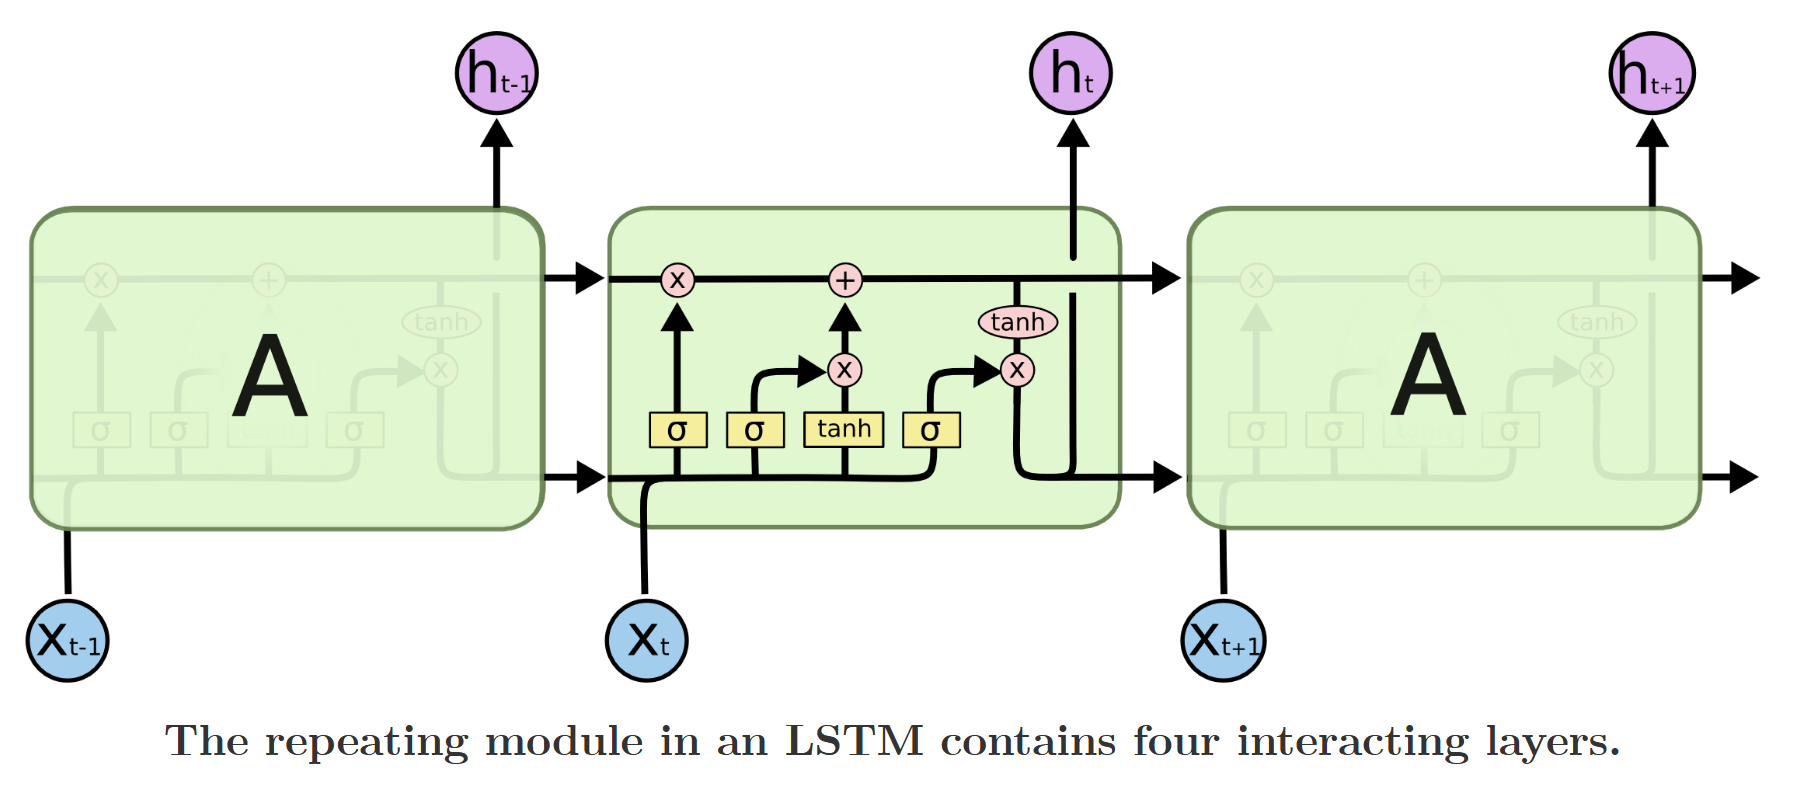

In [ ]:
class LSTMCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation = torch.nn.Sigmoid()
        self.input_gate_input_layer = torch.nn.Linear(input_size, hidden_size, bias=bias)
        self.input_gate_hidden_layer = torch.nn.Linear(hidden_size, hidden_size, bias=bias)
        self.forget_gate_input_layer = torch.nn.Linear(input_size, hidden_size, bias=bias)
        self.forget_gate_hidden_layer = torch.nn.Linear(hidden_size, hidden_size, bias=bias)
        self.gate_input_layer = torch.nn.Linear(input_size, hidden_size, bias=bias)
        self.gate_hidden_layer = torch.nn.Linear(hidden_size, hidden_size, bias=bias)
        self.output_gate_input_layer = torch.nn.Linear(input_size, hidden_size, bias=bias)
        self.output_gate_hidden_layer = torch.nn.Linear(hidden_size, hidden_size, bias=bias)

    def forward(self, x):
        output = list()
        ht, ct = torch.rand((x.shape[0], self.hidden_size)).to(x.device), torch.rand((x.shape[0], self.hidden_size)).to(x.device)
        ht, ct = ht/torch.sqrt(torch.sum(torch.square(ht), dim=0)), ct/torch.sqrt(torch.sum(torch.square(ct), dim=0))
        for i in range(x.shape[1]):
            it = self.activation(self.input_gate_input_layer(x[:,i]) + self.input_gate_hidden_layer(ht))
            ft = self.activation(self.forget_gate_input_layer(x[:,i]) + self.forget_gate_hidden_layer(ht))
            gt = torch.nn.Tanh()(self.gate_input_layer(x[:,i]) + self.gate_hidden_layer(ht))
            ot = self.activation(self.output_gate_input_layer(x[:,i]) + self.output_gate_hidden_layer(ht))
            ct = ft*ct + it*gt
            ht = ot*torch.nn.Tanh()(ct)
            output.append(ht)
        output = torch.stack(output)
        output = torch.swapdims(output, 0, 1)
        return output

## Define the Custom LSTM model

In [ ]:
class LSTM(torch.nn.Module):
    def __init__(self, num_layers, input_size, hidden_size, bias, device):
        super(LSTM, self).__init__()
        # Stack up RNN cells to produce a deep RNN model
        self.LSTM_layers = list()
        for i in range(num_layers):
            if i == 0:
                self.LSTM_layers.append(LSTMCell(input_size, hidden_size, bias).to(device))
            else:
                self.LSTM_layers.append(LSTMCell(hidden_size, hidden_size, bias).to(device))
        self.LSTM_layers = torch.nn.Sequential(*self.LSTM_layers)
        # The final output layer
        self.linear = torch.nn.Linear(hidden_size, 1)
        # Define the optimizer
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
        # Define the objective function
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        x = self.LSTM_layers(x)
        x = self.linear(x[:,-1]).squeeze()
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        self.optimizer.zero_grad()
        preds = self.forward(x.float())
        loss = self.criterion(preds, y.float())
        loss.backward()
        self.optimizer.step()
        return loss.item(), preds.numpy(force=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x.float())
        loss = self.criterion(preds, y.float())
        return loss.item(), preds.numpy(force=True)

## Perform Training and Validation using Pytorch RNN

In [ ]:
num_layers = 4
input_size = X_train.shape[-1]
hidden_size = 128
num_epochs = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(num_layers, input_size, hidden_size, True, device).to(device)

train_epoch_loss = list()
val_epoch_loss = list()
min_val_loss = np.inf
for epoch in tqdm(range(num_epochs)):
    # Training loop
    train_iter_loss = list()
    model.train()
    for batch_idx, batch in enumerate(train_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.training_step(batch, batch_idx)
        train_iter_loss.append(loss)
    train_epoch_loss.append(sum(train_iter_loss)/len(train_iter_loss))
    # print("\nAverage Training MSE in Epoch", epoch+1, ":", train_epoch_loss[-1], "\n")

    # Validation loop
    val_iter_loss = list()
    model.eval()
    for batch_idx, batch in enumerate(val_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.validation_step(batch, batch_idx)
        val_iter_loss.append(loss)
    val_epoch_loss.append(sum(val_iter_loss)/len(val_iter_loss))
    if val_epoch_loss[-1] < min_val_loss:
        min_val_loss = val_epoch_loss[-1]
        best_model = deepcopy(model)
    # print("\nAverage Validation MSE in Epoch", epoch+1, ":", val_epoch_loss[-1], "\n")

100%|██████████| 200/200 [01:27<00:00,  2.28it/s]


## Plot the training and validation losses

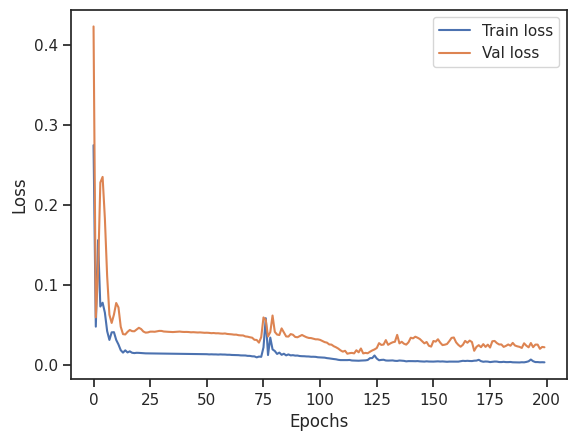

In [ ]:
sns.lineplot(x=np.arange(num_epochs), y=train_epoch_loss, label="Train loss")
sns.lineplot(x=np.arange(num_epochs), y=val_epoch_loss, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Get all the predictions on the train and validation set

In [ ]:
train_data_loader = data_module.data_loader(X_train, Y_train, shuffle=False)
train_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc="Predicting on Train set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    train_total_predictions.extend(preds)
train_total_predictions = np.asarray(train_total_predictions)
train_total_predictions = scaler.inverse_transform(np.reshape(train_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_train, (-1, 1)))[:,0]
print("Training MSE:", np.mean(np.square(train_total_predictions - ground_truth)), "\n\n")

val_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(val_data_loader), total=len(val_data_loader), desc="Predicting on Val set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    val_total_predictions.extend(preds)
val_total_predictions = np.asarray(val_total_predictions)
val_total_predictions = scaler.inverse_transform(np.reshape(val_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_val, (-1, 1)))[:,0]
print("Validation MSE:", np.mean(np.square(val_total_predictions - ground_truth)), "\n\n")

test_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Predicting on Test set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    test_total_predictions.extend(preds)
test_total_predictions = np.asarray(test_total_predictions)
test_total_predictions = scaler.inverse_transform(np.reshape(test_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_test, (-1, 1)))[:,0]
print("Test MSE:", np.mean(np.square(test_total_predictions - ground_truth)))


Predicting on Train set: 100%|██████████| 3/3 [00:00<00:00, 22.63it/s]


Training MSE: 500.2119881073431 




Predicting on Val set: 100%|██████████| 1/1 [00:00<00:00, 20.15it/s]


Validation MSE: 1565.309891959303 




Predicting on Test set: 100%|██████████| 1/1 [00:00<00:00, 22.98it/s]

Test MSE: 6844.45672094535


## Now, plot the ground truth and corresponding predictions

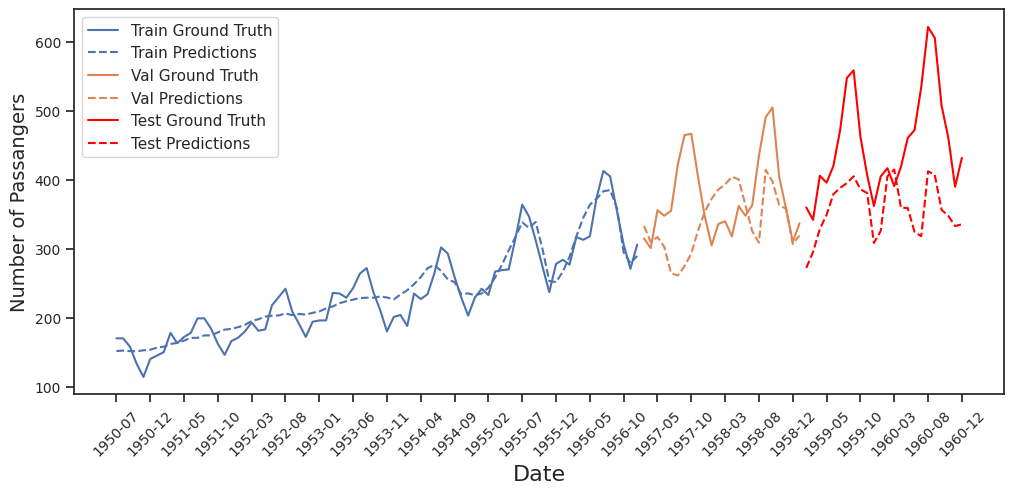

In [ ]:

plt.figure(figsize=(12, 5))
y_value = scaler.inverse_transform(np.reshape(df_train["#Passengers"][window_size:], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:])), y=y_value, label="Train Ground Truth", color="#4c72b0")
sns.lineplot(x=np.arange(len(df_train[window_size:])), y=train_total_predictions, label="Train Predictions", color="#4c72b0", linestyle="--")

y_value = scaler.inverse_transform(np.reshape(df_val["#Passengers"], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:]), len(df_train[window_size:])+len(df_val)), y=y_value, label="Val Ground Truth", color="#dd8452")
sns.lineplot(x=np.arange(len(df_train[window_size:]), len(df_train[window_size:])+len(df_val)), y=val_total_predictions, label="Val Predictions", color="#dd8452", linestyle="--")

y_value = scaler.inverse_transform(np.reshape(df_test["#Passengers"], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:])+len(df_val), len(df_train[window_size:])+len(df_val)+len(df_test)), y=y_value, label="Test Ground Truth", color="red")
sns.lineplot(x=np.arange(len(df_train[window_size:])+len(df_val), len(df_train[window_size:])+len(df_val)+len(df_test)), y=test_total_predictions, label="Test Predictions", color="red", linestyle="--")

train_ticks = [i for idx, i in enumerate(df_train["Month"].dt.strftime("%Y-%m").tolist()[window_size:]) if idx%5==0]
val_ticks = [i for idx, i in enumerate(df_val["Month"].dt.strftime("%Y-%m").tolist()) if (idx+1)%5==0] + [df_val["Month"].dt.strftime("%Y-%m").tolist()[-1]]
test_ticks = [i for idx, i in enumerate(df_test["Month"].dt.strftime("%Y-%m").tolist()) if (idx+1)%5==0] + [df_test["Month"].dt.strftime("%Y-%m").tolist()[-1]]
plt.xticks(np.arange(0, len(df_train[window_size:])+len(df_val)+len(df_test)+1, 5), train_ticks + val_ticks + test_ticks, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of Passangers", fontsize=14)
plt.legend()
plt.show()

## Define the Pytorch LSTM model

In [ ]:
class PytorchLSTM(torch.nn.Module):
    def __init__(self, num_layers, input_size, hidden_size, bias, device):
        super(PytorchLSTM, self).__init__()
        self.LSTM = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bias=bias, batch_first=True, device=device)
        # The final output layer
        self.linear = torch.nn.Linear(hidden_size, 1)
        # Define the optimizer
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=0.001)
        # Define the objective function
        self.criterion = torch.nn.MSELoss()

    def forward(self, x):
        ht, ct = torch.rand((self.LSTM.num_layers, x.shape[0], self.LSTM.hidden_size)).to(x.device), torch.rand((self.LSTM.num_layers, x.shape[0], self.LSTM.hidden_size)).to(x.device)
        ht, ct = ht/torch.sqrt(torch.sum(torch.square(ht), dim=0)), ct/torch.sqrt(torch.sum(torch.square(ct), dim=0))
        x, (_, _) = self.LSTM(x, (ht, ct))
        x = self.linear(x[:,-1]).squeeze()
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        self.optimizer.zero_grad()
        preds = self.forward(x.float())
        loss = self.criterion(preds, y.float())
        loss.backward()
        self.optimizer.step()
        return loss.item(), preds.numpy(force=True)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x.float())
        loss = self.criterion(preds, y.float())
        return loss.item(), preds.numpy(force=True)

## Perform Training and Validation using Pytorch LSTM

In [ ]:
num_layers = 4
input_size = X_train.shape[-1]
hidden_size = 128
num_epochs = 2000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PytorchLSTM(num_layers, input_size, hidden_size, True, device).to(device)

train_epoch_loss = list()
val_epoch_loss = list()
min_val_loss = np.inf
for epoch in tqdm(range(num_epochs)):
    # Training loop
    train_iter_loss = list()
    model.train()
    for batch_idx, batch in enumerate(train_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.training_step(batch, batch_idx)
        train_iter_loss.append(loss)
    train_epoch_loss.append(sum(train_iter_loss)/len(train_iter_loss))
    # print("\nAverage Training MSE in Epoch", epoch+1, ":", train_epoch_loss[-1], "\n")

    # Validation loop
    val_iter_loss = list()
    model.eval()
    for batch_idx, batch in enumerate(val_data_loader):
        batch = (batch[0].to(device), batch[1].to(device))
        loss, _ = model.validation_step(batch, batch_idx)
        val_iter_loss.append(loss)
    val_epoch_loss.append(sum(val_iter_loss)/len(val_iter_loss))
    if val_epoch_loss[-1] < min_val_loss:
        min_val_loss = val_epoch_loss[-1]
        best_model = deepcopy(model)
    # print("\nAverage Validation MSE in Epoch", epoch+1, ":", val_epoch_loss[-1], "\n")

100%|██████████| 2000/2000 [00:31<00:00, 62.73it/s]


## Plot the training and validation losses

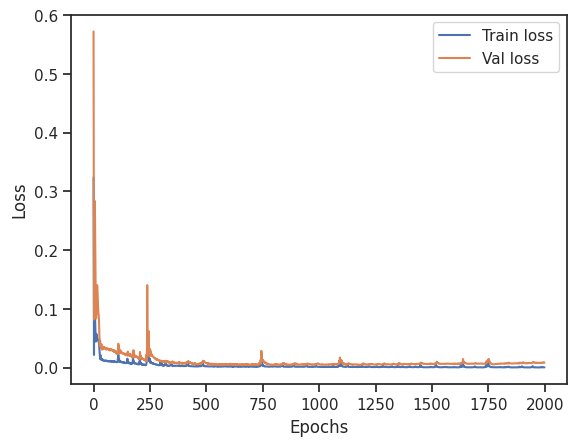

In [ ]:
sns.lineplot(x=np.arange(num_epochs), y=train_epoch_loss, label="Train loss")
sns.lineplot(x=np.arange(num_epochs), y=val_epoch_loss, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Get all the predictions on the train and validation set

In [ ]:
train_data_loader = data_module.data_loader(X_train, Y_train, shuffle=False)
train_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc="Predicting on Train set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    train_total_predictions.extend(preds)
train_total_predictions = np.asarray(train_total_predictions)
train_total_predictions = scaler.inverse_transform(np.reshape(train_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_train, (-1, 1)))[:,0]
print("Training MSE:", np.mean(np.square(train_total_predictions - ground_truth)), "\n\n")

val_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(val_data_loader), total=len(val_data_loader), desc="Predicting on Val set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    val_total_predictions.extend(preds)
val_total_predictions = np.asarray(val_total_predictions)
val_total_predictions = scaler.inverse_transform(np.reshape(val_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_val, (-1, 1)))[:,0]
print("Validation MSE:", np.mean(np.square(val_total_predictions - ground_truth)), "\n\n")

test_total_predictions = list()
for batch_idx, batch in tqdm(enumerate(test_data_loader), total=len(test_data_loader), desc="Predicting on Test set"):
    batch = (batch[0].to(device), batch[1].to(device))
    _, preds = best_model.validation_step(batch, batch_idx)
    test_total_predictions.extend(preds)
test_total_predictions = np.asarray(test_total_predictions)
test_total_predictions = scaler.inverse_transform(np.reshape(test_total_predictions, (-1, 1)))[:,0]
ground_truth = scaler.inverse_transform(np.reshape(Y_test, (-1, 1)))[:,0]
print("Test MSE:", np.mean(np.square(test_total_predictions - ground_truth)))


Predicting on Train set:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
Predicting on Train set: 100%|██████████| 3/3 [00:00<00:00, 152.58it/s]


Training MSE: 159.89535143298022 




Predicting on Val set:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
Predicting on Val set: 100%|██████████| 1/1 [00:00<00:00, 197.43it/s]


Validation MSE: 447.42206310040393 




Predicting on Test set:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(
Predicting on Test set: 100%|██████████| 1/1 [00:00<00:00, 131.50it/s]

Test MSE: 3248.582141493643


## Now, plot the ground truth and corresponding predictions

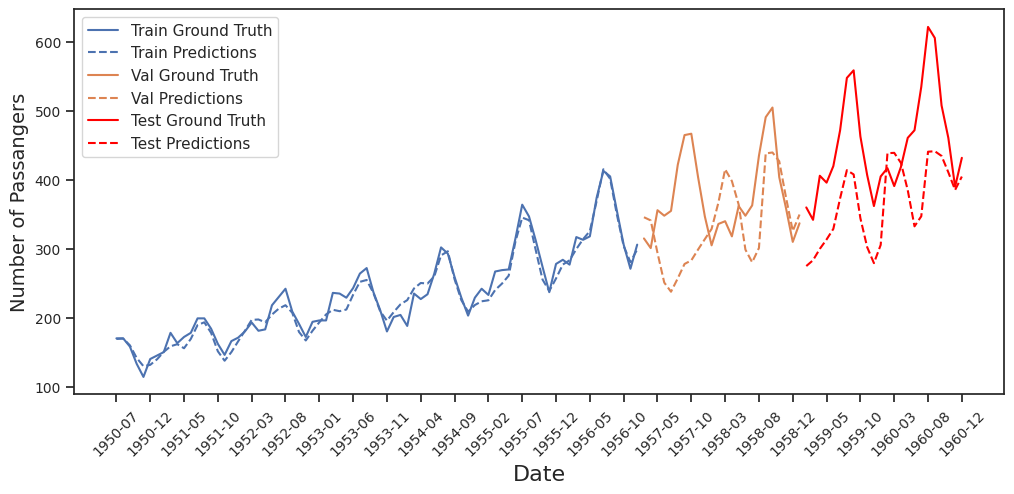

In [ ]:

plt.figure(figsize=(12, 5))
y_value = scaler.inverse_transform(np.reshape(df_train["#Passengers"][window_size:], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:])), y=y_value, label="Train Ground Truth", color="#4c72b0")
sns.lineplot(x=np.arange(len(df_train[window_size:])), y=train_total_predictions, label="Train Predictions", color="#4c72b0", linestyle="--")

y_value = scaler.inverse_transform(np.reshape(df_val["#Passengers"], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:]), len(df_train[window_size:])+len(df_val)), y=y_value, label="Val Ground Truth", color="#dd8452")
sns.lineplot(x=np.arange(len(df_train[window_size:]), len(df_train[window_size:])+len(df_val)), y=val_total_predictions, label="Val Predictions", color="#dd8452", linestyle="--")

y_value = scaler.inverse_transform(np.reshape(df_test["#Passengers"], (-1, 1)))[:,0]
sns.lineplot(x=np.arange(len(df_train[window_size:])+len(df_val), len(df_train[window_size:])+len(df_val)+len(df_test)), y=y_value, label="Test Ground Truth", color="red")
sns.lineplot(x=np.arange(len(df_train[window_size:])+len(df_val), len(df_train[window_size:])+len(df_val)+len(df_test)), y=test_total_predictions, label="Test Predictions", color="red", linestyle="--")

train_ticks = [i for idx, i in enumerate(df_train["Month"].dt.strftime("%Y-%m").tolist()[window_size:]) if idx%5==0]
val_ticks = [i for idx, i in enumerate(df_val["Month"].dt.strftime("%Y-%m").tolist()) if (idx+1)%5==0] + [df_val["Month"].dt.strftime("%Y-%m").tolist()[-1]]
test_ticks = [i for idx, i in enumerate(df_test["Month"].dt.strftime("%Y-%m").tolist()) if (idx+1)%5==0] + [df_test["Month"].dt.strftime("%Y-%m").tolist()[-1]]
plt.xticks(np.arange(0, len(df_train[window_size:])+len(df_val)+len(df_test)+1, 5), train_ticks + val_ticks + test_ticks, rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of Passangers", fontsize=14)
plt.legend()
plt.show()